<a href="https://colab.research.google.com/github/SifatSharif/Basic-Prigram/blob/main/PPI_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PPI GNN (Pro Version)
Upgrades: Feature standardization, Early stopping, Hard negatives, Edge-feature concat, ROC/PR plots, LaTeX export.
Inputs: `biogrid_node_features.csv`, `biogrid_edges_aggregated.csv`.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# ===== Install (Colab only) =====
# যদি আগে install করা থাকে, এই সেল skip করতে পারো

!pip install torch_geometric torch_scatter torch_sparse -q
!pip install umap-learn -q
!pip install scikit-learn -q


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [6]:
# ===== Imports =====

import pandas as pd
import numpy as np
import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, GCNConv, GATConv
from torch_geometric.utils import negative_sampling

from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
import umap

import matplotlib.pyplot as plt

import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [7]:
# ===== Load your CSVs =====
# প্রয়োজন অনুযায়ী path পরিবর্তন করো

node_path = "/content/drive/MyDrive/Research_Dataset/biogrid_node_features.csv"
edge_path = "/content/drive/MyDrive/Research_Dataset/biogrid_edges_aggregated.csv"

node_df = pd.read_csv(node_path)
edge_df = pd.read_csv(edge_path)

print("Node df head:")
display(node_df.head())

print("Edge df head:")
display(edge_df.head())
print("Num nodes (rows):", len(node_df))
print("Num edges (rows before filtering):", len(edge_df))


Node df head:


,protein,degree,clustering,pagerank,score_mean_node,score_max_node,score_std_node,high_throughput_node,low_throughput_node,pub_count,type_physical,type_genetic
0,FLNC,11,0.000000,0.000081,0.0,0.0,0.0,0,25,10,25,0
1,MAP2K4,15,0.123810,0.000067,0.0,0.0,0.0,0,24,15,21,3
2,ACTN2,12,0.075758,0.000073,3.0,3.0,0.0,1,26,12,27,0
3,MYPN,7,0.142857,0.000056,0.0,0.0,0.0,0,14,3,14,0
4,ACVR1,48,0.005319,0.000292,0.0,0.0,0.0,39,15,10,54,0


Edge df head:


,source,target,same_organism,score_mean,score_max,score_std,support_count,high_throughput_support,pub_support,exp_Negative Genetic,...,exp_Synthetic Lethality,exp_Synthetic Growth Defect,exp_Biochemical Activity,exp_Phenotypic Enhancement,exp_Dosage Rescue,exp_Affinity Capture-RNA,exp_Synthetic Rescue,exp_PCA,exptype_physical,exptype_genetic
0,FLNC,MAP2K4,1,0.0,0.0,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,3,0
1,ACTN2,MYPN,1,0.0,0.0,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,2,0
2,ACVR1,FNTA,1,0.0,0.0,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,GATA2,PML,1,0.0,0.0,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,3,0
4,RPA2,STAT3,1,0.0,0.0,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,3,0


Num nodes (rows): 26786
Num edges (rows before filtering): 173215


In [8]:
# ===== Protein -> index mapping =====

assert "protein" in node_df.columns, "Node file must have 'protein' column"

proteins = node_df["protein"].tolist()
protein2idx = {p: i for i, p in enumerate(proteins)}
idx2protein = {i: p for p, i in protein2idx.items()}

num_nodes = len(proteins)
print("Num nodes:", num_nodes)

# ===== Node feature columns =====
# এখানে আমরা যতটা পারে smart ভাবে columns detect করবো

candidate_node_cols = [
    'degree',
    'clustering',
    'pagerank',
    'score_mean_node',
    'score_max_node',
    'score_std_node',
    'high_throughput_node',
    'low_throughput_node',
    'pub_count',
    'type_physical',
    'type_genetic'
]

node_feature_cols = [c for c in candidate_node_cols if c in node_df.columns]
print("Using node feature columns:", node_feature_cols)

x_full = torch.tensor(node_df[node_feature_cols].values, dtype=torch.float)

print("x_full shape:", x_full.shape)

# ===== Topology-only feature columns (for ablation) =====
candidate_topo_cols = ['degree', 'clustering', 'pagerank']
topo_feature_cols = [c for c in candidate_topo_cols if c in node_df.columns]
print("Topology-only columns:", topo_feature_cols)

if len(topo_feature_cols) > 0:
    x_topo = torch.tensor(node_df[topo_feature_cols].values, dtype=torch.float)
else:
    # fallback: শুধু degree থাকলে সেটা, না থাকলে all-ones
    if 'degree' in node_df.columns:
        x_topo = torch.tensor(node_df[['degree']].values, dtype=torch.float)
        topo_feature_cols = ['degree']
    else:
        x_topo = torch.ones((num_nodes, 1), dtype=torch.float)
        topo_feature_cols = ['ones']

print("x_topo shape:", x_topo.shape)


Num nodes: 26786
Using node feature columns: ['degree', 'clustering', 'pagerank', 'score_mean_node', 'score_max_node', 'score_std_node', 'high_throughput_node', 'low_throughput_node', 'pub_count', 'type_physical', 'type_genetic']
x_full shape: torch.Size([26786, 11])
Topology-only columns: ['degree', 'clustering', 'pagerank']
x_topo shape: torch.Size([26786, 3])


In [9]:
# ===== Filter edges to only those whose proteins exist in node_df =====

mask_source = edge_df['source'].isin(protein2idx)
mask_target = edge_df['target'].isin(protein2idx)
valid_edges_df = edge_df[mask_source & mask_target].copy()

print("Valid edges after node filter:", len(valid_edges_df))

# Map to integer indices
valid_edges_df['src_idx'] = valid_edges_df['source'].map(protein2idx)
valid_edges_df['dst_idx'] = valid_edges_df['target'].map(protein2idx)

# ===== Detect high-throughput column =====
ht_cols = [c for c in valid_edges_df.columns if 'high_throughput' in c.lower()]
print("Detected high-throughput columns:", ht_cols)
high_throughput_col = ht_cols[0] if len(ht_cols) > 0 else None
if high_throughput_col:
    print("Using high-throughput col:", high_throughput_col)
else:
    print("No high-throughput column found. Ablation (high-throughput only) will be trivial all-edges.")

# ===== Edge features (for baselines) =====

candidate_edge_cols = [
    'same_organism',
    'score_mean',
    'score_max',
    'score_std',
    'support_count',
    'pub_support',
    'exptype_physical',
    'exptype_genetic'
]

edge_feature_cols = [c for c in candidate_edge_cols if c in valid_edges_df.columns]
print("Using edge feature columns:", edge_feature_cols)


Valid edges after node filter: 173215
Detected high-throughput columns: ['high_throughput_support']
Using high-throughput col: high_throughput_support
Using edge feature columns: ['same_organism', 'score_mean', 'score_max', 'score_std', 'support_count', 'pub_support', 'exptype_physical', 'exptype_genetic']


In [10]:
# ===== Build undirected edge_index from valid_edges_df =====

src_idx = valid_edges_df['src_idx'].to_numpy()
dst_idx = valid_edges_df['dst_idx'].to_numpy()

edge_index_base = torch.tensor(
    np.vstack([src_idx, dst_idx]),
    dtype=torch.long
)

# Make undirected (add reverse edges)
edge_index_undirected = torch.cat(
    [edge_index_base, edge_index_base[[1, 0], :]],
    dim=1
)

print("Directed edge_index_base:", edge_index_base.shape)
print("Undirected edge_index:", edge_index_undirected.shape)

# ===== Edge split helper =====

def split_edges(edge_index, train_ratio=0.8, val_ratio=0.1, seed=42):
    num_edges = edge_index.size(1)
    g = torch.Generator()
    g.manual_seed(seed)
    perm = torch.randperm(num_edges, generator=g)

    train_end = int(train_ratio * num_edges)
    val_end   = int((train_ratio + val_ratio) * num_edges)

    train_pos = edge_index[:, perm[:train_end]]
    val_pos   = edge_index[:, perm[train_end:val_end]]
    test_pos  = edge_index[:, perm[val_end:]]

    return train_pos, val_pos, test_pos

train_pos_edge_all, val_pos_edge_all, test_pos_edge_all = split_edges(edge_index_undirected)

print("Train pos edges:", train_pos_edge_all.size(1))
print("Val pos edges:",   val_pos_edge_all.size(1))
print("Test pos edges:",  test_pos_edge_all.size(1))


Directed edge_index_base: torch.Size([2, 173215])
Undirected edge_index: torch.Size([2, 346430])
Train pos edges: 277144
Val pos edges: 34643
Test pos edges: 34643


In [11]:
# ===== Data objects =====

data_full = Data(
    x=x_full,
    edge_index=edge_index_undirected
)
data_topo = Data(
    x=x_topo,
    edge_index=edge_index_undirected
)

data_full = data_full.to(device)
data_topo = data_topo.to(device)

print(data_full)
print(data_topo)


Data(x=[26786, 11], edge_index=[2, 346430])
Data(x=[26786, 3], edge_index=[2, 346430])


In [12]:
# ===== GNN encoder definitions =====

class GNNEncoderGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2):
        super().__init__()
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.convs.append(GCNConv(hidden_channels, out_channels))
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = self.act(x)
            x = self.dropout(x)
        x = self.convs[-1](x, edge_index)
        return x

class GNNEncoderSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2):
        super().__init__()
        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = self.act(x)
            x = self.dropout(x)
        x = self.convs[-1](x, edge_index)
        return x

class GNNEncoderGAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, num_layers=2):
        super().__init__()
        self.convs = nn.ModuleList()
        self.convs.append(GATConv(in_channels, hidden_channels, heads=heads, concat=True))
        hidden_dim = hidden_channels * heads
        for _ in range(num_layers - 2):
            self.convs.append(GATConv(hidden_dim, hidden_channels, heads=heads, concat=True))
            hidden_dim = hidden_channels * heads
        self.convs.append(GATConv(hidden_dim, out_channels, heads=1, concat=False))
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = self.act(x)
            x = self.dropout(x)
        x = self.convs[-1](x, edge_index)
        return x

class LinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1)
        )

    def forward(self, h, edge_index):
        src = h[edge_index[0]]
        dst = h[edge_index[1]]
        out = torch.cat([src, dst], dim=-1)
        out = self.mlp(out).squeeze(-1)
        return out


In [13]:
criterion = nn.BCEWithLogitsLoss()

def get_neg_edges(edge_index_all, num_nodes, num_samples):
    neg_edge_index = negative_sampling(
        edge_index=edge_index_all,
        num_nodes=num_nodes,
        num_neg_samples=num_samples
    )
    return neg_edge_index

def get_pos_neg_edges(split, train_pos, val_pos, test_pos, edge_index_all, num_nodes):
    if split == "train":
        pos_edge = train_pos
    elif split == "val":
        pos_edge = val_pos
    else:
        pos_edge = test_pos

    num_pos = pos_edge.size(1)
    neg_edge = get_neg_edges(edge_index_all, num_nodes, num_pos)
    return pos_edge.to(device), neg_edge.to(device)

def train_one_epoch(encoder, predictor, data, train_pos, optimizer, edge_index_all):
    encoder.train()
    predictor.train()

    optimizer.zero_grad()
    h = encoder(data.x, data.edge_index)

    pos_edge, neg_edge = get_pos_neg_edges(
        "train", train_pos, None, None,
        edge_index_all=edge_index_all,
        num_nodes=data.num_nodes
    )

    pos_out = predictor(h, pos_edge)
    neg_out = predictor(h, neg_edge)

    pos_label = torch.ones(pos_out.size(0), device=device)
    neg_label = torch.zeros(neg_out.size(0), device=device)

    out = torch.cat([pos_out, neg_out], dim=0)
    label = torch.cat([pos_label, neg_label], dim=0)

    loss = criterion(out, label)
    loss.backward()
    optimizer.step()

    return loss.item()

@torch.no_grad()
def eval_split(encoder, predictor, data, train_pos, val_pos, test_pos, split, edge_index_all):
    encoder.eval()
    predictor.eval()

    h = encoder(data.x, data.edge_index)

    pos_edge, neg_edge = get_pos_neg_edges(
        split, train_pos, val_pos, test_pos,
        edge_index_all=edge_index_all,
        num_nodes=data.num_nodes
    )

    pos_out = predictor(h, pos_edge).cpu()
    neg_out = predictor(h, neg_edge).cpu()

    y_true = np.concatenate([
        np.ones(pos_out.shape[0]),
        np.zeros(neg_out.shape[0])
    ])

    y_scores = torch.cat([pos_out, neg_out], dim=0).numpy()

    auc = roc_auc_score(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)

    return auc, ap

def run_gnn_experiment(
    model_type,
    data,
    train_pos,
    val_pos,
    test_pos,
    edge_index_all,
    hidden_channels=64,
    out_channels=64,
    num_layers=2,
    epochs=50,
    lr=1e-3,
    weight_decay=1e-4,
    verbose=True
):
    in_channels = data.x.size(1)

    if model_type == "GCN":
        encoder = GNNEncoderGCN(in_channels, hidden_channels, out_channels, num_layers).to(device)
    elif model_type == "SAGE":
        encoder = GNNEncoderSAGE(in_channels, hidden_channels, out_channels, num_layers).to(device)
    elif model_type == "GAT":
        encoder = GNNEncoderGAT(in_channels, hidden_channels, out_channels, num_layers=num_layers).to(device)
    else:
        raise ValueError("Unknown model_type")

    predictor = LinkPredictor(out_channels, hidden_channels).to(device)

    optimizer = torch.optim.Adam(
        list(encoder.parameters()) + list(predictor.parameters()),
        lr=lr,
        weight_decay=weight_decay
    )

    best_val_auc = 0.0
    best_res = None

    for epoch in range(1, epochs+1):
        loss = train_one_epoch(
            encoder, predictor, data,
            train_pos,
            optimizer,
            edge_index_all
        )
        val_auc, val_ap = eval_split(
            encoder, predictor, data,
            train_pos, val_pos, test_pos,
            "val",
            edge_index_all
        )
        test_auc, test_ap = eval_split(
            encoder, predictor, data,
            train_pos, val_pos, test_pos,
            "test",
            edge_index_all
        )

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_res = {
                "val_auc": val_auc,
                "val_ap": val_ap,
                "test_auc": test_auc,
                "test_ap": test_ap,
                "encoder": encoder,
                "predictor": predictor
            }

        if verbose and epoch % 10 == 0:
            print(f"[{model_type}] Epoch {epoch:03d} | Loss: {loss:.4f} | "
                  f"Val AUC: {val_auc:.4f}, AP: {val_ap:.4f} | "
                  f"Test AUC: {test_auc:.4f}, AP: {test_ap:.4f}")

    print(f"[{model_type}] Best by Val AUC: "
          f"Val AUC={best_res['val_auc']:.4f}, AP={best_res['val_ap']:.4f} | "
          f"Test AUC={best_res['test_auc']:.4f}, AP={best_res['test_ap']:.4f}")

    return best_res


In [14]:
print("=== Experiment 1: Full features + All edges ===")

exp1_results = {}

for model in ["GCN", "SAGE", "GAT"]:
    print("\nRunning", model)
    res = run_gnn_experiment(
        model_type=model,
        data=data_full,
        train_pos=train_pos_edge_all,
        val_pos=val_pos_edge_all,
        test_pos=test_pos_edge_all,
        edge_index_all=edge_index_undirected,
        epochs=50
    )
    exp1_results[model] = res

exp1_results


=== Experiment 1: Full features + All edges ===

Running GCN
[GCN] Epoch 010 | Loss: 0.5538 | Val AUC: 0.8291, AP: 0.8796 | Test AUC: 0.8266, AP: 0.8782
[GCN] Epoch 020 | Loss: 0.5208 | Val AUC: 0.8748, AP: 0.9057 | Test AUC: 0.8757, AP: 0.9068
[GCN] Epoch 030 | Loss: 0.4916 | Val AUC: 0.9033, AP: 0.9220 | Test AUC: 0.9024, AP: 0.9220
[GCN] Epoch 040 | Loss: 0.4674 | Val AUC: 0.9046, AP: 0.9228 | Test AUC: 0.9038, AP: 0.9224
[GCN] Epoch 050 | Loss: 0.4414 | Val AUC: 0.9219, AP: 0.9338 | Test AUC: 0.9203, AP: 0.9330
[GCN] Best by Val AUC: Val AUC=0.9305, AP=0.9394 | Test AUC=0.9290, AP=0.9383

Running SAGE
[SAGE] Epoch 010 | Loss: 1.2475 | Val AUC: 0.8677, AP: 0.8755 | Test AUC: 0.8667, AP: 0.8737
[SAGE] Epoch 020 | Loss: 0.8678 | Val AUC: 0.8561, AP: 0.8728 | Test AUC: 0.8578, AP: 0.8751
[SAGE] Epoch 030 | Loss: 0.5623 | Val AUC: 0.9173, AP: 0.9227 | Test AUC: 0.9184, AP: 0.9246
[SAGE] Epoch 040 | Loss: 0.4489 | Val AUC: 0.9353, AP: 0.9356 | Test AUC: 0.9359, AP: 0.9370
[SAGE] Epoch 05

{'GCN': {'val_auc': np.float64(0.9305439143079351),
  'val_ap': np.float64(0.9393770780173553),
  'test_auc': np.float64(0.9289689192925101),
  'test_ap': np.float64(0.9383315154432024),
  'encoder': GNNEncoderGCN(
    (convs): ModuleList(
      (0): GCNConv(11, 64)
      (1): GCNConv(64, 64)
    )
    (act): ReLU()
    (dropout): Dropout(p=0.3, inplace=False)
  ),
  'predictor': LinkPredictor(
    (mlp): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )},
 'SAGE': {'val_auc': np.float64(0.9462856949812588),
  'val_ap': np.float64(0.9487323268189264),
  'test_auc': np.float64(0.9451778852040471),
  'test_ap': np.float64(0.9477937352220663),
  'encoder': GNNEncoderSAGE(
    (convs): ModuleList(
      (0): SAGEConv(11, 64, aggr=mean)
      (1): SAGEConv(64, 64, aggr=mean)
    )
    (act): ReLU()
    (dropout): Dropout(p=0.3, inplace=False)
  ),
  'predictor': LinkPredictor(
 

In [15]:
print("=== Ablation 1: Topology-only node features (no expression / other features) ===")

abl1_results = {}

for model in ["GCN", "SAGE", "GAT"]:
    print("\nRunning", model)
    res = run_gnn_experiment(
        model_type=model,
        data=data_topo,
        train_pos=train_pos_edge_all,
        val_pos=val_pos_edge_all,
        test_pos=test_pos_edge_all,
        edge_index_all=edge_index_undirected,
        epochs=50
    )
    abl1_results[model] = res

abl1_results


=== Ablation 1: Topology-only node features (no expression / other features) ===

Running GCN
[GCN] Epoch 010 | Loss: 0.5507 | Val AUC: 0.8567, AP: 0.8896 | Test AUC: 0.8556, AP: 0.8890
[GCN] Epoch 020 | Loss: 0.5355 | Val AUC: 0.8891, AP: 0.9123 | Test AUC: 0.8892, AP: 0.9124
[GCN] Epoch 030 | Loss: 0.5215 | Val AUC: 0.8960, AP: 0.9165 | Test AUC: 0.8960, AP: 0.9177
[GCN] Epoch 040 | Loss: 0.5092 | Val AUC: 0.9063, AP: 0.9217 | Test AUC: 0.9085, AP: 0.9243
[GCN] Epoch 050 | Loss: 0.4983 | Val AUC: 0.9000, AP: 0.9189 | Test AUC: 0.9005, AP: 0.9191
[GCN] Best by Val AUC: Val AUC=0.9112, AP=0.9248 | Test AUC=0.9114, AP=0.9257

Running SAGE
[SAGE] Epoch 010 | Loss: 0.6341 | Val AUC: 0.8702, AP: 0.8892 | Test AUC: 0.8710, AP: 0.8897
[SAGE] Epoch 020 | Loss: 0.5140 | Val AUC: 0.9437, AP: 0.9449 | Test AUC: 0.9425, AP: 0.9438
[SAGE] Epoch 030 | Loss: 0.3968 | Val AUC: 0.9455, AP: 0.9457 | Test AUC: 0.9458, AP: 0.9464
[SAGE] Epoch 040 | Loss: 0.4256 | Val AUC: 0.9455, AP: 0.9473 | Test AUC: 0

{'GCN': {'val_auc': np.float64(0.9112071504069864),
  'val_ap': np.float64(0.9247908685397541),
  'test_auc': np.float64(0.911358918440016),
  'test_ap': np.float64(0.9257184895685058),
  'encoder': GNNEncoderGCN(
    (convs): ModuleList(
      (0): GCNConv(3, 64)
      (1): GCNConv(64, 64)
    )
    (act): ReLU()
    (dropout): Dropout(p=0.3, inplace=False)
  ),
  'predictor': LinkPredictor(
    (mlp): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )},
 'SAGE': {'val_auc': np.float64(0.9539233222444007),
  'val_ap': np.float64(0.9551681685224397),
  'test_auc': np.float64(0.953088518280209),
  'test_ap': np.float64(0.9545521514503973),
  'encoder': GNNEncoderSAGE(
    (convs): ModuleList(
      (0): SAGEConv(3, 64, aggr=mean)
      (1): SAGEConv(64, 64, aggr=mean)
    )
    (act): ReLU()
    (dropout): Dropout(p=0.3, inplace=False)
  ),
  'predictor': LinkPredictor(
    (

In [16]:
print("=== Ablation 2: High-throughput edges only (GraphSAGE) ===")

if high_throughput_col is None:
    print("No high-throughput column found; using all edges only.")
    abl2_result = None
else:
    ht_edges_df = valid_edges_df[valid_edges_df[high_throughput_col] > 0].copy()
    print("Num high-throughput edges:", len(ht_edges_df))

    src_ht = ht_edges_df['src_idx'].to_numpy()
    dst_ht = ht_edges_df['dst_idx'].to_numpy()

    edge_index_ht = torch.tensor(
        np.vstack([src_ht, dst_ht]),
        dtype=torch.long
    )

    edge_index_ht_undirected = torch.cat(
        [edge_index_ht, edge_index_ht[[1, 0], :]],
        dim=1
    )

    train_pos_ht, val_pos_ht, test_pos_ht = split_edges(edge_index_ht_undirected)

    abl2_result = run_gnn_experiment(
        model_type="SAGE",
        data=data_full,
        train_pos=train_pos_ht,
        val_pos=val_pos_ht,
        test_pos=test_pos_ht,
        edge_index_all=edge_index_ht_undirected,
        epochs=50
    )

abl2_result


=== Ablation 2: High-throughput edges only (GraphSAGE) ===
Num high-throughput edges: 129478
[SAGE] Epoch 010 | Loss: 0.4449 | Val AUC: 0.9546, AP: 0.9555 | Test AUC: 0.9557, AP: 0.9568
[SAGE] Epoch 020 | Loss: 0.3152 | Val AUC: 0.9621, AP: 0.9628 | Test AUC: 0.9627, AP: 0.9634
[SAGE] Epoch 030 | Loss: 0.2997 | Val AUC: 0.9664, AP: 0.9671 | Test AUC: 0.9669, AP: 0.9675
[SAGE] Epoch 040 | Loss: 0.2709 | Val AUC: 0.9713, AP: 0.9709 | Test AUC: 0.9715, AP: 0.9707
[SAGE] Epoch 050 | Loss: 0.2563 | Val AUC: 0.9728, AP: 0.9717 | Test AUC: 0.9725, AP: 0.9704
[SAGE] Best by Val AUC: Val AUC=0.9734, AP=0.9719 | Test AUC=0.9721, AP=0.9704


{'val_auc': np.float64(0.9733583351072597),
 'val_ap': np.float64(0.9718587124935945),
 'test_auc': np.float64(0.9720801768896837),
 'test_ap': np.float64(0.970351130208395),
 'encoder': GNNEncoderSAGE(
   (convs): ModuleList(
     (0): SAGEConv(11, 64, aggr=mean)
     (1): SAGEConv(64, 64, aggr=mean)
   )
   (act): ReLU()
   (dropout): Dropout(p=0.3, inplace=False)
 ),
 'predictor': LinkPredictor(
   (mlp): Sequential(
     (0): Linear(in_features=128, out_features=64, bias=True)
     (1): ReLU()
     (2): Linear(in_features=64, out_features=1, bias=True)
   )
 )}

Baselines: Logistic Regression & Random Forest

এখানে আমরা same train/val/test split use করে edge-level feature বানাবো:
node(u) + node(v) + edge_features (যদি থাকে)।
যেখানে edge feature নেই (negative edges), সেখানে 0 fill করবো।

In [28]:
from collections import defaultdict

def build_edge_feature_matrix(
    pos_edge, neg_edge,
    node_features,  # np array [num_nodes, node_feat_dim]
    valid_edges_df,
    edge_feature_cols
):
    """
    pos_edge, neg_edge: torch.LongTensor [2, num_edges]
    node_features: np array of node features
    valid_edges_df: DataFrame with src_idx, dst_idx, plus edge_feature_cols
    """
    # Map (min(u,v), max(u,v)) -> edge feature row
    edge_feat_dict = {}
    if len(edge_feature_cols) > 0:
        for _, row in valid_edges_df.iterrows():
            u = int(row['src_idx'])
            v = int(row['dst_idx'])
            key = (min(u, v), max(u, v))
            edge_feat_dict[key] = row[edge_feature_cols].values.astype(float)

    def build_for_edges(edge_tensor, label_value):
        feats = []
        labels = []
        edge_tensor = edge_tensor.cpu().numpy()
        for u, v in edge_tensor.T:
            uf = node_features[u]
            vf = node_features[v]
            key = (min(int(u), int(v)), max(int(u), int(v)))
            if key in edge_feat_dict:
                ef = edge_feat_dict[key]
            else:
                # no edge feature (for negative edges usually)
                ef = np.zeros(len(edge_feature_cols), dtype=float)
            fv = np.concatenate([uf, vf], axis=0)
            feats.append(fv)
            labels.append(label_value)
        return np.array(feats), np.array(labels)

    X_pos, y_pos = build_for_edges(pos_edge, 1)
    X_neg, y_neg = build_for_edges(neg_edge, 0)

    X = np.vstack([X_pos, X_neg])
    y = np.concatenate([y_pos, y_neg])


    return X, y

# Build train/val/test datasets
node_features_np = x_full.cpu().numpy()
print("Node features for baseline:", node_features_np.shape)

# For consistency, we will use same neg-sampling seeds
def sample_neg_edges_for_split(split, train_pos, val_pos, test_pos):
    if split == "train":
        pos = train_pos
    elif split == "val":
        pos = val_pos
    else:
        pos = test_pos
    num_pos = pos.size(1)
    neg = get_neg_edges(edge_index_undirected, num_nodes, num_pos)
    return pos, neg

# Train
train_pos_for_baseline, train_neg = sample_neg_edges_for_split(
    "train", train_pos_edge_all, val_pos_edge_all, test_pos_edge_all
)
X_train, y_train = build_edge_feature_matrix(
    train_pos_for_baseline, train_neg,
    node_features_np,
    valid_edges_df,
    edge_feature_cols
)

# Val
val_pos_for_baseline, val_neg = sample_neg_edges_for_split(
    "val", train_pos_edge_all, val_pos_edge_all, test_pos_edge_all
)
X_val, y_val = build_edge_feature_matrix(
    val_pos_for_baseline, val_neg,
    node_features_np,
    valid_edges_df,
    edge_feature_cols
)

# Test
test_pos_for_baseline, test_neg = sample_neg_edges_for_split(
    "test", train_pos_edge_all, val_pos_edge_all, test_pos_edge_all
)
X_test, y_test = build_edge_feature_matrix(
    test_pos_for_baseline, test_neg,
    node_features_np,
    valid_edges_df,
    edge_feature_cols
)
# ✅ Check for data leakage (train vs test overlap)
train_pairs = set(map(tuple, train_pos_for_baseline.T))
test_pairs  = set(map(tuple, test_pos_for_baseline.T))

print("Overlap between train and test:", len(train_pairs & test_pairs))


print("Train shape:", X_train.shape, "Val shape:", X_val.shape, "Test shape:", X_test.shape)


Node features for baseline: (26786, 11)
Overlap between train and test: 0
Train shape: (554288, 22) Val shape: (69286, 22) Test shape: (69286, 22)


In [21]:
baseline_results = {}

# Logistic Regression (with liblinear or saga)
logreg = LogisticRegression(max_iter=1000, n_jobs=-1)
logreg.fit(X_train, y_train)

# Validation
val_scores = logreg.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_scores)
val_ap  = average_precision_score(y_val, val_scores)

# Test
test_scores = logreg.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_scores)
test_ap  = average_precision_score(y_test, test_scores)

baseline_results['LogisticRegression'] = {
    "val_auc": val_auc,
    "val_ap": val_ap,
    "test_auc": test_auc,
    "test_ap": test_ap
}

print("Logistic Regression:")
print(" Val AUC:", val_auc, "Val AP:", val_ap)
print(" Test AUC:", test_auc, "Test AP:", test_ap)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)

val_scores = rf.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_scores)
val_ap  = average_precision_score(y_val, val_scores)

test_scores = rf.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_scores)
test_ap  = average_precision_score(y_test, test_scores)

baseline_results['RandomForest'] = {
    "val_auc": val_auc,
    "val_ap": val_ap,
    "test_auc": test_auc,
    "test_ap": test_ap
}

print("\nRandom Forest:")
print(" Val AUC:", val_auc, "Val AP:", val_ap)
print(" Test AUC:", test_auc, "Test AP:", test_ap)

baseline_results


Logistic Regression:
 Val AUC: 0.9037067649240565 Val AP: 0.9067227536553171
 Test AUC: 0.9034725434186498 Test AP: 0.9062729890585616

Random Forest:
 Val AUC: 0.9834487053824116 Val AP: 0.9804311188632275
 Test AUC: 0.983140833979592 Test AP: 0.9799075190364142


{'LogisticRegression': {'val_auc': np.float64(0.9037067649240565),
  'val_ap': np.float64(0.9067227536553171),
  'test_auc': np.float64(0.9034725434186498),
  'test_ap': np.float64(0.9062729890585616)},
 'RandomForest': {'val_auc': np.float64(0.9834487053824116),
  'val_ap': np.float64(0.9804311188632275),
  'test_auc': np.float64(0.983140833979592),
  'test_ap': np.float64(0.9799075190364142)}}

Node embedding shape: (26786, 64)


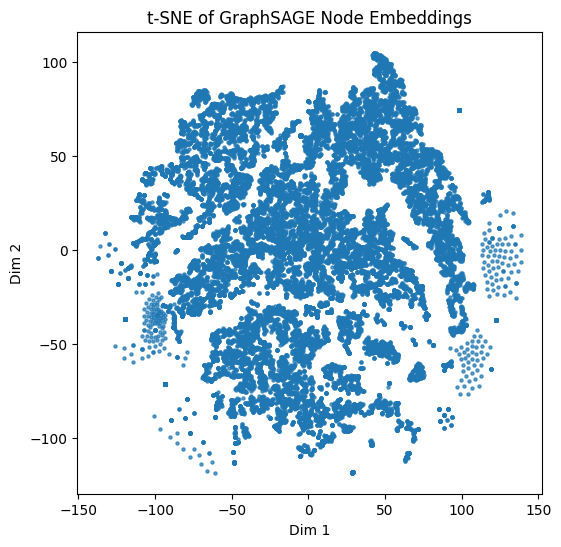

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


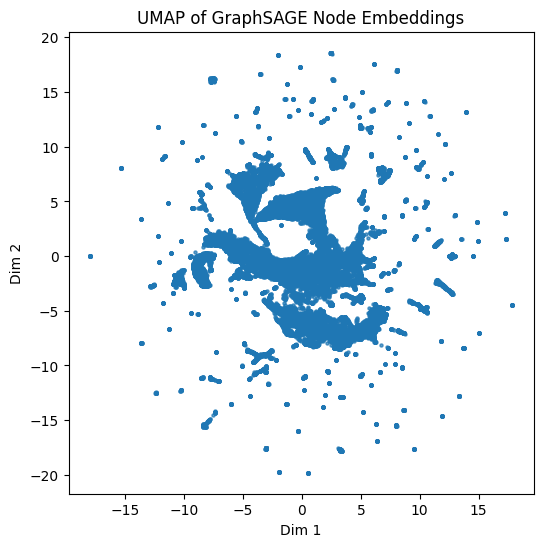

In [19]:
# ===== t-SNE & UMAP on node embeddings =====

# Best SAGE model (from Experiment 1)
sage_best = exp1_results["SAGE"]
sage_encoder = sage_best["encoder"]

sage_encoder.eval()
with torch.no_grad():
    h_sage = sage_encoder(data_full.x, data_full.edge_index).cpu().numpy()

print("Node embedding shape:", h_sage.shape)

# t-SNE (2D)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
h_tsne = tsne.fit_transform(h_sage)

plt.figure(figsize=(6,6))
plt.scatter(h_tsne[:,0], h_tsne[:,1], s=5, alpha=0.7)
plt.title("t-SNE of GraphSAGE Node Embeddings")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()

# UMAP (2D)
umap_model = umap.UMAP(n_components=2, random_state=42)
h_umap = umap_model.fit_transform(h_sage)

plt.figure(figsize=(6,6))
plt.scatter(h_umap[:,0], h_umap[:,1], s=5, alpha=0.7)
plt.title("UMAP of GraphSAGE Node Embeddings")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()
